# Final Project

As a part of final assignment, I would like to walk through and illustrate the each steps of my project. 

# Importing libraries and checking versions

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

import lightgbm as lgb
from sklearn.metrics import mean_squared_error,r2_score

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import warnings
warnings.filterwarnings('ignore')

In [2]:
for p in [np, pd, sns, lgb]:
    print (p.__name__, p.__version__)

numpy 1.12.1
pandas 0.22.0
seaborn 0.7.1
lightgbm 2.1.0


The versions should be same to below.

    numpy 1.12.1
    pandas 0.22.0
    seaborn 0.7.1
    lightgbm 2.1.0

# Defining the downcast

After importing the libraries, we would like to define the downcast_dtypes function.
It will be used later, especially for saving the memory.

In [3]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Loading Data

In [4]:
item_categories = pd.read_csv('.\data\item_categories.csv')
items = pd.read_csv('.\data\items.csv')
sales = pd.read_csv('.\data\sales_train_v2.csv')
shops = pd.read_csv('.\data\shops.csv')
#test = pd.read_csv('.\data\test.csv')
test = pd.read_csv(r'C:\Users\ISHIKAWA\Kaggle\Final Project\data\test.csv')

We will use shop_id which is appeared in test data.

In [5]:
sales = sales[sales['shop_id'].isin(test['shop_id'].unique())]

# EDA

For EDA process, we will manipulate sales data to see monthly sales.

In [6]:
sales_month = sales.groupby(['date_block_num','shop_id','item_id'],as_index=False)['item_cnt_day'].sum()
sales_month = sales_month.rename(columns={'item_cnt_day':'item_cnt_month'})
sales_month.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


After that, to see the seasonality we plot the  sales summed by each months.

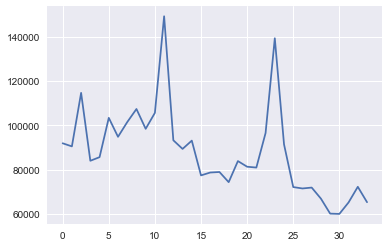

In [7]:
plt.plot(sales_month.groupby('date_block_num')['item_cnt_month'].sum())

In [8]:
sales_month.groupby('date_block_num')['item_cnt_month'].sum()

date_block_num
0      91888.0
1      90483.0
2     114684.0
3      83983.0
4      85617.0
5     103391.0
6      94814.0
7     101461.0
8     107386.0
9      98427.0
10    105648.0
11    149312.0
12     93242.0
13     89346.0
14     93088.0
15     77371.0
16     78675.0
17     78909.0
18     74313.0
19     83844.0
20     81291.0
21     80915.0
22     96534.0
23    139377.0
24     91408.0
25     72096.0
26     71466.0
27     71869.0
28     66871.0
29     60098.0
30     59961.0
31     65163.0
32     72220.0
33     65259.0
Name: item_cnt_month, dtype: float64

From this plot, we can observe 2 things.

First, monthly sales is decresing year by year.

Second, there are two spikes on the plot.

It seems date_block_num is 11 and 23. That means every December sales was skyrocketted.

Then we checked the distribution of shop_id & item_id on date_block_num=33, which is the month before test data.

In [9]:
sales_month[sales_month['date_block_num']==33].groupby('shop_id').size()

shop_id
2      440
3      391
4      478
5      615
6      954
7      642
10     288
12     650
14     594
15     693
16     535
18     681
19     824
21     974
22     626
24     660
25    2210
26     680
28    1398
31    2222
34     246
35     820
36     258
37     444
38     605
39     482
41     476
42    1573
44     549
45     466
46     700
47     831
48     653
49     482
50     603
52     573
53     646
55     470
56     802
57    1216
58     804
59     500
dtype: int64

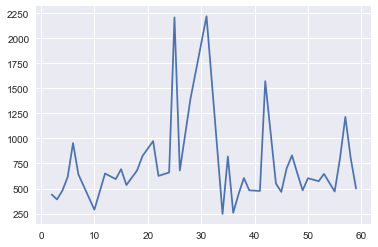

In [10]:
plt.plot(sales_month[sales_month['date_block_num']==33].groupby('shop_id').size())

In [11]:
sales_month[sales_month['date_block_num']==33].groupby('item_id').size()

item_id
30        1
31       14
32       15
33       13
40        1
42        1
45        1
49        2
51        2
53        1
57        1
59        2
62       17
64        1
67        6
69        1
70        6
76        6
79        2
87        1
91       15
93        1
113       1
138       2
139       1
146       1
147       1
149       4
153       1
154       1
157       1
158       1
159       1
161       1
166       1
174       1
181       1
182       1
183       1
184       1
185       1
186       1
187       1
188       1
189       1
190       1
191       1
192       1
193       1
194       1
195       1
201       1
202       3
208       1
213       4
225       3
226       1
228       1
229       1
234       4
238       2
245       1
248       3
253       2
259       2
269       1
284       1
291       1
293       1
294       1
308       3
313       1
314       1
315       1
322       1
324       2
325       4
353       1
356       1
364       1
388       1
405       1
407     

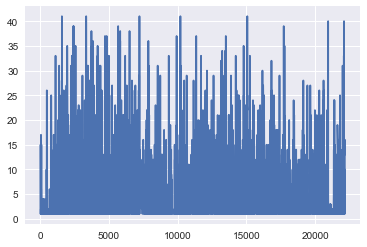

In [12]:
plt.plot(sales_month[sales_month['date_block_num']==33].groupby('item_id').size())

Conducting the same thing on test data.

In [13]:
test.groupby('shop_id').size()

shop_id
2     5100
3     5100
4     5100
5     5100
6     5100
7     5100
10    5100
12    5100
14    5100
15    5100
16    5100
18    5100
19    5100
21    5100
22    5100
24    5100
25    5100
26    5100
28    5100
31    5100
34    5100
35    5100
36    5100
37    5100
38    5100
39    5100
41    5100
42    5100
44    5100
45    5100
46    5100
47    5100
48    5100
49    5100
50    5100
52    5100
53    5100
55    5100
56    5100
57    5100
58    5100
59    5100
dtype: int64

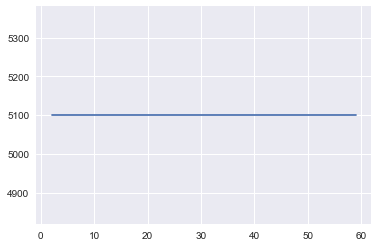

In [14]:
plt.plot(test.groupby('shop_id').size())

In [15]:
test.groupby('item_id').size()

item_id
30       42
31       42
32       42
33       42
38       42
42       42
45       42
51       42
53       42
57       42
59       42
62       42
64       42
67       42
69       42
70       42
72       42
76       42
80       42
83       42
88       42
91       42
93       42
109      42
138      42
140      42
149      42
153      42
154      42
166      42
168      42
173      42
180      42
202      42
204      42
205      42
213      42
226      42
234      42
237      42
248      42
249      42
253      42
254      42
259      42
269      42
302      42
308      42
313      42
315      42
325      42
342      42
353      42
356      42
388      42
402      42
407      42
408      42
413      42
421      42
428      42
430      42
445      42
448      42
454      42
464      42
473      42
474      42
477      42
478      42
480      42
482      42
486      42
491      42
492      42
494      42
496      42
502      42
503      42
504      42
505      42
508      42
515     

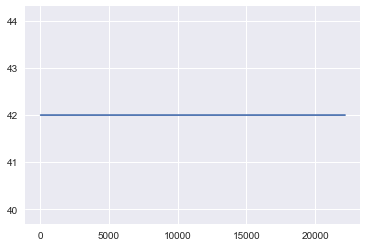

In [16]:
plt.plot(test.groupby('item_id').size())

The distribution of shop_id & item_id in test data is so weired.


From the observation, we infered test data was intentionally increased by the competition host.

It makes difficult to predict test data, because the result will iclude so many 0s.

Additionaly, it also makes difficult to do a right cross validation. The distribution of training and test data is completly different.


To deal with these problems, we will manipulate training data in the same way as the host did.

That means we will add every combination of shop_id & item_id to training data.

Of course it makes so many 0s added to the training data, however in this case it will work.


In [17]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [18]:
# Groupby data to get shop-item-month aggregates
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# Fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 

# Clip the target
gb['target'] = np.clip(gb['target'],0,40)

# Join it to the grid
all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Add 'item_category_id'
all_data = pd.merge(all_data, items[['item_id','item_category_id']],how='left',on='item_id')
test = pd.merge(test, items[['item_id','item_category_id']],how='left',on='item_id')
gb = pd.merge(gb, items[['item_id','item_category_id']],how='left',on='item_id')


Add target data grouped by each IDs.

In [19]:
cols = ['item_id','shop_id','item_category_id']

for col in cols:
    temp = gb.groupby(['date_block_num',col],as_index=False)['target'].sum()
    temp = temp.rename(columns={'target':col+'_target'})
    all_data = pd.merge(all_data,temp, how='left',on=['date_block_num',col])
    all_data.fillna(0,inplace=True)
    
all_data = downcast_dtypes(all_data)
del grid, gb, temp 
gc.collect();

In [20]:
test['date_block_num'] = 34

In [21]:
idtest = test['ID'].values
test.drop('ID', axis=1, inplace=True)

# Feature Engineering

In this section, we will generate some new features.

In [22]:
#Add 'shop_id' and 'item_category_id'.
for dataset in [all_data, test]:
    dataset['shop_category'] = dataset['shop_id'].astype(str)+'_'+dataset['item_category_id'].astype(str)

In [23]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_category_id,item_id_target,shop_id_target,item_category_id_target,shop_category
0,59,22154,0,1.0,37,16.0,2021.0,4122.0,59_37
1,59,2552,0,0.0,58,0.0,2021.0,219.0,59_58
2,59,2554,0,0.0,58,1.0,2021.0,219.0,59_58
3,59,2555,0,0.0,56,1.0,2021.0,181.0,59_56
4,59,2564,0,0.0,59,4.0,2021.0,471.0,59_59


Doing mean encoding and std encoding for each categorical data.

In [24]:
cols = ['shop_id', 'item_id', 'item_category_id', 'shop_category']

prior = all_data['target'].mean()
prior_std = all_data['target'].std()

for col in tqdm_notebook(cols):
    
    #Mean encoding
    mean_df = all_data.groupby(['date_block_num',col])['target'].mean().reset_index()
    mean_df = mean_df.rename(columns={'target':col+'_mean'})
    all_data = pd.merge(all_data, mean_df, how = 'left',on=['date_block_num',col])
    test[col+'_mean'] = test[col].map(all_data.groupby(col)['target'].mean())
    all_data[col+'_mean'].fillna(prior, inplace=True)
    test[col+'_mean'].fillna(prior, inplace=True)
    
    #Std encoding
    std_df = all_data.groupby(['date_block_num',col])['target'].std().reset_index()
    std_df = std_df.rename(columns={'target':col+'_std'})
    all_data = pd.merge(all_data, std_df, how = 'left',on=['date_block_num',col])
    test[col+'_std'] = test[col].map(all_data.groupby(col)['target'].std())
    all_data[col+'_std'].fillna(prior_std, inplace=True)
    test[col+'_std'].fillna(prior_std, inplace=True)
    
del mean_df,std_df
gc.collect()

185

In [25]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_category_id,item_id_target,shop_id_target,item_category_id_target,shop_category,shop_id_mean,shop_id_std,item_id_mean,item_id_std,item_category_id_mean,item_category_id_std,shop_category_mean,shop_category_std
0,59,22154,0,1.0,37,16.0,2021.0,4122.0,59_37,0.269251,1.097441,0.484848,0.939455,0.209931,0.811909,0.100840,0.343162
1,59,2552,0,0.0,58,0.0,2021.0,219.0,59_58,0.269251,1.097441,0.000000,0.000000,0.049897,0.241573,0.000000,0.000000
2,59,2554,0,0.0,58,1.0,2021.0,219.0,59_58,0.269251,1.097441,0.030303,0.174078,0.049897,0.241573,0.000000,0.000000
3,59,2555,0,0.0,56,1.0,2021.0,181.0,59_56,0.269251,1.097441,0.030303,0.174078,0.063044,0.272803,0.011494,0.107211
4,59,2564,0,0.0,59,4.0,2021.0,471.0,59_59,0.269251,1.097441,0.121212,0.331434,0.096437,0.350996,0.013514,0.115852


In [26]:
all_data = downcast_dtypes(all_data)

Making lagged data.

In [27]:
index_cols = index_cols + ['item_category_id','shop_category']

# List of columns that we will use to create lags
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [12,5,4,3,2,1]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)
    test = pd.merge(test, train_shift, on=index_cols, how='left').fillna(0)
    all_data = all_data[all_data['date_block_num']>=(23-month_shift)]

del train_shift
gc.collect()

588

In [28]:
all_data.head()

,shop_id,item_id,date_block_num,target,item_category_id,item_id_target,shop_id_target,item_category_id_target,shop_category,shop_id_mean,shop_id_std,item_id_mean,item_id_std,item_category_id_mean,item_category_id_std,shop_category_mean,shop_category_std,item_category_id_mean_lag_12,item_category_id_std_lag_12,item_category_id_target_lag_12,item_id_mean_lag_12,item_id_std_lag_12,item_id_target_lag_12,shop_category_mean_lag_12,shop_category_std_lag_12,...,target_lag_3,item_category_id_mean_lag_2,item_category_id_std_lag_2,item_category_id_target_lag_2,item_id_mean_lag_2,item_id_std_lag_2,item_id_target_lag_2,shop_category_mean_lag_2,shop_category_std_lag_2,shop_id_mean_lag_2,shop_id_std_lag_2,shop_id_target_lag_2,target_lag_2,item_category_id_mean_lag_1,item_category_id_std_lag_1,item_category_id_target_lag_1,item_id_mean_lag_1,item_id_std_lag_1,item_id_target_lag_1,shop_category_mean_lag_1,shop_category_std_lag_1,shop_id_mean_lag_1,shop_id_std_lag_1,shop_id_target_lag_1,target_lag_1
241449,37,3460,22,34.0,28,1131.0,1346.0,6644.0,37_28,0.2237,1.466089,27.585365,11.502121,1.976205,6.569793,2.256098,6.995256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0
241450,37,21272,22,0.0,61,7.0,1346.0,578.0,37_61,0.2237,1.466089,0.170732,0.441726,0.132996,0.980022,0.056604,0.582772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.121371,0.430959,209.0,0.219512,0.612870,9.0,0.0,0.0,0.192035,1.17,1109.0,0.0,0.064254,0.324441,245.0,0.219512,0.524985,9.0,0.010753,0.103695,0.172865,0.912439,1018.0,0.0
241451,37,21274,22,0.0,61,6.0,1346.0,578.0,37_61,0.2237,1.466089,0.146341,0.357839,0.132996,0.980022,0.056604,0.582772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.121371,0.430959,209.0,0.390244,0.862498,16.0,0.0,0.0,0.192035,1.17,1109.0,0.0,0.064254,0.324441,245.0,0.268293,0.742442,11.0,0.010753,0.103695,0.172865,0.912439,1018.0,0.0
241452,37,21275,22,0.0,61,15.0,1346.0,578.0,37_61,0.2237,1.466089,0.365854,0.968403,0.132996,0.980022,0.056604,0.582772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.121371,0.430959,209.0,0.292683,0.679849,12.0,0.0,0.0,0.192035,1.17,1109.0,0.0,0.064254,0.324441,245.0,0.365854,0.915317,15.0,0.010753,0.103695,0.172865,0.912439,1018.0,0.0
241453,37,21276,22,0.0,61,11.0,1346.0,578.0,37_61,0.2237,1.466089,0.268293,0.742442,0.132996,0.980022,0.056604,0.582772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.121371,0.430959,209.0,0.292683,0.782429,12.0,0.0,0.0,0.192035,1.17,1109.0,0.0,0.064254,0.324441,245.0,0.243902,0.623718,10.0,0.010753,0.103695,0.172865,0.912439,1018.0,0.0


We will remove some features which may lead data leakage.

In [29]:
all_data.drop(['shop_id_target', 'item_id_target', 'item_category_id_target','shop_category',\
              'shop_id_mean','item_id_mean','item_category_id_mean','shop_category_mean',\
              'shop_id_std','item_id_std','item_category_id_std','shop_category_std'],axis=1,inplace=True)

test.drop(['shop_category','shop_id_mean','item_id_mean','item_category_id_mean','shop_category_mean',\
          'shop_id_std','item_id_std','item_category_id_std','shop_category_std'],axis=1,inplace=True)

In [30]:
train_df = all_data.copy()

del all_data
gc.collect()

20

# Cross Validation

After generating features, we will proceed to cross validation.

We already got the same data distribution in train and test data.
So considering these data are Time Series, we will take 'date_block_num'=33 as a CV data.

In [31]:
#Set the train and cv data.
train = train_df[(train_df['date_block_num']<=32)&(train_df['date_block_num']>=23)]
cv = train_df[train_df['date_block_num']==33]
y_train = train['target']
X_train = train.drop('target', axis=1)
y_cv = cv['target']
X_cv = cv.drop('target', axis=1)

del train,cv
gc.collect()

X_train = downcast_dtypes(X_train)
X_cv = downcast_dtypes(X_cv)

We will set early stopping rounds for LightGBM to find the appropriate number of iterations.

In [32]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'learning_rate': 0.1, 
               'objective': 'mse', 
               'num_leaves': 2**4,
               'verbose':0 
              }

model_lgb = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 500,\
                       valid_sets=lgb.Dataset(X_cv, label=y_cv), early_stopping_rounds=30) 
pred_lgb = model_lgb.predict(X_cv)

print('Test R-squared for LightGBM is %f' % r2_score(y_cv, pred_lgb))


[1]	valid_0's rmse: 1.26562
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's rmse: 1.23349
[3]	valid_0's rmse: 1.20541
[4]	valid_0's rmse: 1.17683
[5]	valid_0's rmse: 1.1524
[6]	valid_0's rmse: 1.1332
[7]	valid_0's rmse: 1.11934
[8]	valid_0's rmse: 1.10348
[9]	valid_0's rmse: 1.09202
[10]	valid_0's rmse: 1.08212
[11]	valid_0's rmse: 1.0746
[12]	valid_0's rmse: 1.06738
[13]	valid_0's rmse: 1.06183
[14]	valid_0's rmse: 1.05638
[15]	valid_0's rmse: 1.05109
[16]	valid_0's rmse: 1.04219
[17]	valid_0's rmse: 1.03871
[18]	valid_0's rmse: 1.03543
[19]	valid_0's rmse: 1.03279
[20]	valid_0's rmse: 1.0309
[21]	valid_0's rmse: 1.02904
[22]	valid_0's rmse: 1.02752
[23]	valid_0's rmse: 1.02589
[24]	valid_0's rmse: 1.02482
[25]	valid_0's rmse: 1.01702
[26]	valid_0's rmse: 1.01013
[27]	valid_0's rmse: 1.0089
[28]	valid_0's rmse: 1.0082
[29]	valid_0's rmse: 1.00816
[30]	valid_0's rmse: 1.00777
[31]	valid_0's rmse: 1.00444
[32]	valid_0's rmse: 1.004
[33]	valid_0's rmse: 0.9995

Best iteration is 125. Great. We will use this later for prediction on test data.

Feature importances are below.

In [33]:
pd.DataFrame(model_lgb.feature_importance(importance_type='gain', iteration=-1),index=X_train.columns).sort_values(by=0, ascending=False)

,0
target_lag_1,5.745012e+06
target_lag_2,1.704026e+06
item_id_mean_lag_1,9.660776e+05
shop_category_mean_lag_1,7.875745e+05
item_category_id,5.857983e+05
target_lag_3,5.152555e+05
date_block_num,4.980340e+05
item_id,4.182847e+05
item_id_target_lag_1,3.041464e+05
item_id_std_lag_3,2.281465e+05


# Submission

We redefine training data to include 'date_block_num'=33.

In [34]:
X_train = train_df[(train_df['date_block_num']<=33)&(train_df['date_block_num']>23)]
y_train = X_train['target'].values
X_train = X_train.drop('target', axis=1)

Retraining the model on the same parameters to CV.

In [35]:
model_lgb = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 125) 

In [36]:
X_test = test.copy()

In [37]:
preds_lgb = model_lgb.predict(X_test)

In [38]:
#Clip the prediction.
test_preds = np.clip(preds_lgb, 0, 20)

In [39]:
solution = pd.DataFrame({"ID":idtest, "item_cnt_month":test_preds})
solution.to_csv('finalproject_48.csv',index=False)